<h1 style="background-color:#8ffaaa;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px"><b><u>Brain Tumor Classification</u></b></h1>


<center><img src="https://media.istockphoto.com/photos/brain-cancer-picture-id174927353?k=6&m=174927353&s=612x612&w=0&h=P3EzH6J-haFHzmKQ8RzkfotD_lsygXzNUL72Dg3pfK0=",height='300',width='600'></center>

<h1><center>INTRODUCTION TO PROBLEM OF BRAIN TUMOR</center></h1>
A Brain tumor is considered as one of the aggressive diseases, among children and adults. Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor. The 5-year survival rate for people with a cancerous brain or CNS tumor is approximately 34 percent for men and36 percent for women. Brain Tumors are classified as: Benign Tumor, Malignant Tumor, Pituitary Tumor, etc. Proper treatment, planning, and accurate diagnostics should be implemented to improve the life expectancy of the patients. The best technique to detect brain tumors is Magnetic Resonance Imaging (MRI). A huge amount of image data is generated through the scans. These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties.

<h5 style="background-color:#f4abcd;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px"><b>Importing Libraries</b></h5>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2
import keras
from keras.applications.vgg16 import preprocess_input,VGG16
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Dropout,GlobalAveragePooling2D,Flatten,Input
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report
from keras.utils.vis_utils import plot_model
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Function to load images

def convert_image_to_dataset(file_location):
    label=0
    df=pd.DataFrame()
    for category in glob(file_location+'/*'):
        for file in tqdm(glob(category+'/*')):
            img_array=cv2.imread(file)
            img_array=cv2.resize(img_array,(224, 224))
            data=pd.DataFrame({'image':[img_array],'label':[label]})
            df=df.append(data)
        label+=1
    return df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Function to convert output labels to its class of tumor.


def inverse_classes(num):
    if num==0:
        return 'Glioma Tumor'
    elif num==1:
        return 'Meningioma Tumor'
    elif num==2:
        return 'No Tumor'
    else:
        return 'Pituitary Tumor'
    

In [ ]:
train_data=convert_image_to_dataset('/content/drive/MyDrive/DWT images/training')
train_x=np.array(train_data.image.to_list())

100%|██████████| 388/388 [00:02<00:00, 129.34it/s]


In [ ]:
test_data=convert_image_to_dataset('/content/drive/MyDrive/DWT images/testing')
test_x=np.array(test_data.image.to_list())

100%|██████████| 31/31 [00:00<00:00, 89.65it/s]


<h1 style="background-color:#f4abcd;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px"><b>Visualizing Dataset</b></h1>


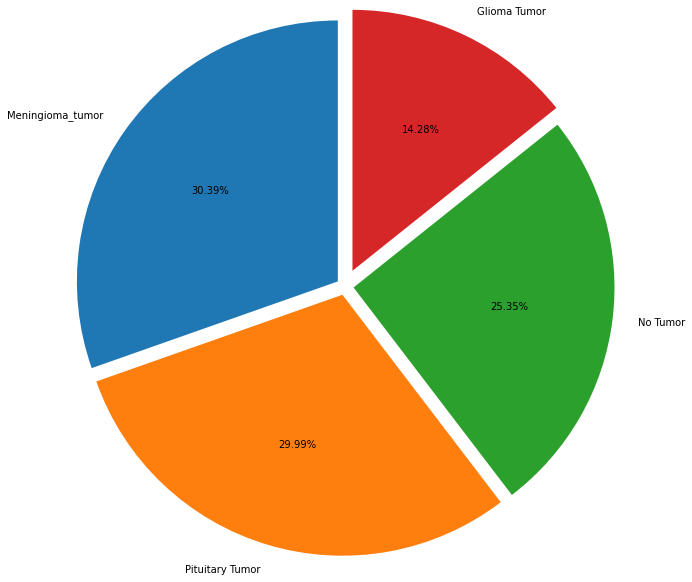

In [ ]:
plt.pie(train_data.label.value_counts(),startangle=90,explode=[0.1,0.1,0.1,0.2],autopct='%0.2f%%',
        labels=['Meningioma_tumor', 'Pituitary Tumor', 'No Tumor', 'Glioma Tumor'],radius=3)
plt.show()

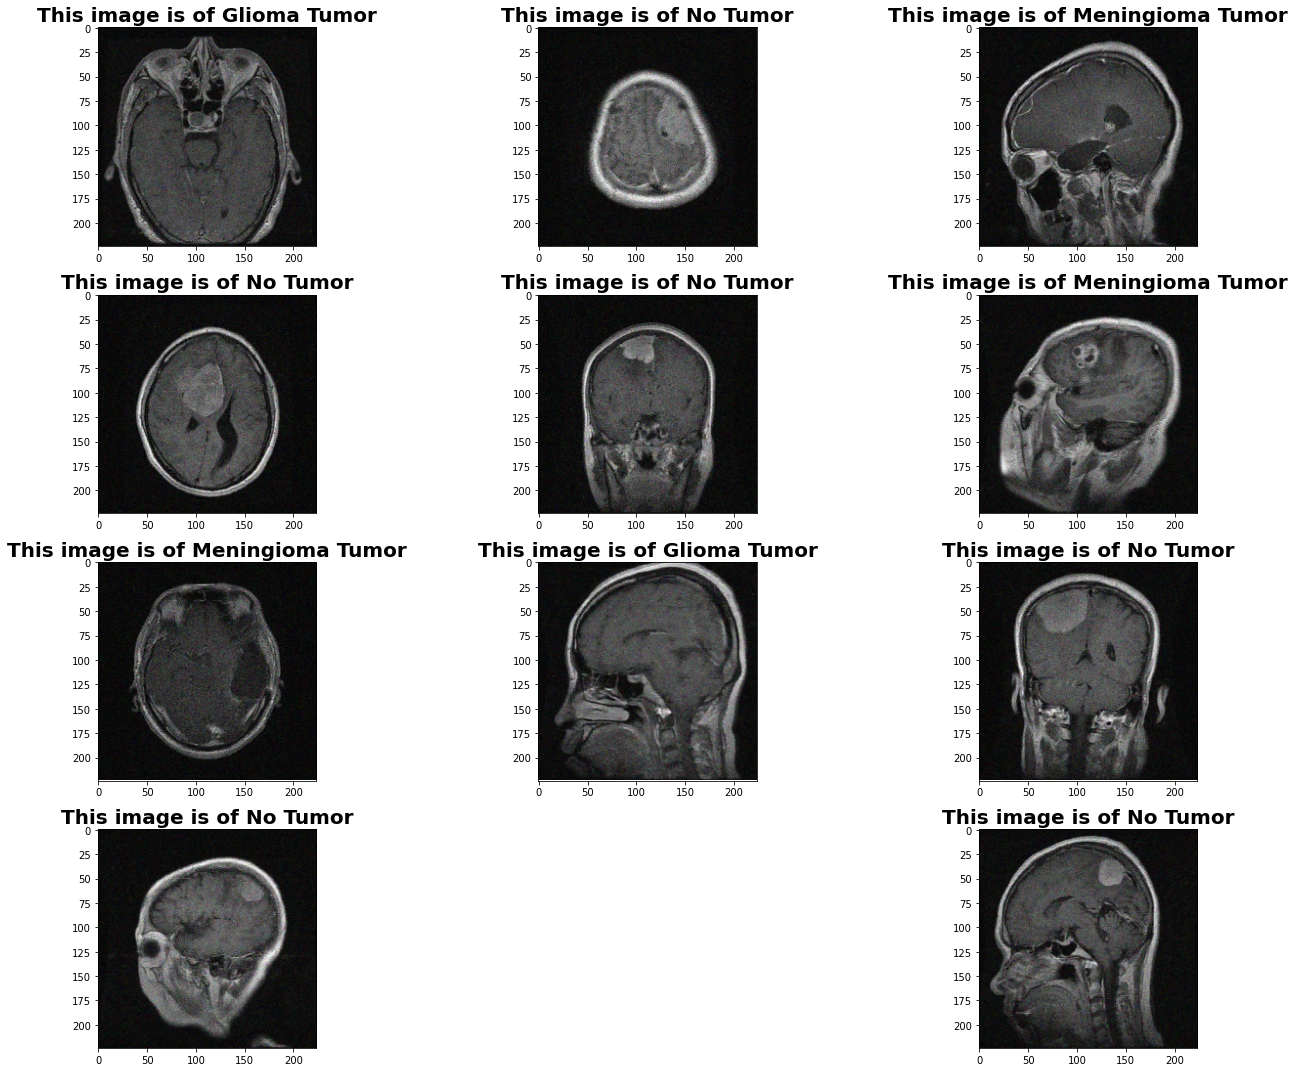

In [ ]:
plt.figure(figsize=(20,15))
for i in range(12):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(2000)
    plt.title('This image is of {0}'.format(inverse_classes(train_data.label[index])),fontdict={'size':20,'weight':'bold'})
    plt.imshow(train_data.image[index])
    plt.tight_layout()

<h1 style="background-color:#f4abcd;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px"><b>Callbacks Functions</b></h1>


In [ ]:
early_stop=EarlyStopping(patience=3)
reduceLR=ReduceLROnPlateau(patience=2)

In [ ]:

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver('')
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.119.153.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.153.186:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Here we are going to explore two processes by which we could solve this problem,

1. Traditional CNN Approach

2. Transfer Learning Approach

<h4 style="background-color:#f4a123;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px" ><b>Traditional CNN Approach</b></h4>


In [ ]:
# instantiating the model in the strategy scope creates the model on the TPU

with tpu_strategy.scope():
    model_cnn=Sequential()
    model_cnn.add(Input(shape=(224,224,3)))
    model_cnn.add(Conv2D(128,(3,3)))
    model_cnn.add(MaxPooling2D((2,2)))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(64,(3,3)))
    model_cnn.add(MaxPooling2D((2,2)))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(32,(3,3)))
    model_cnn.add(MaxPooling2D((2,2)))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128,activation='relu'))
    model_cnn.add(Dropout(0.2))
    model_cnn.add(Dense(64,activation='relu'))
    model_cnn.add(Dense(4,activation='softmax'))
    model_cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

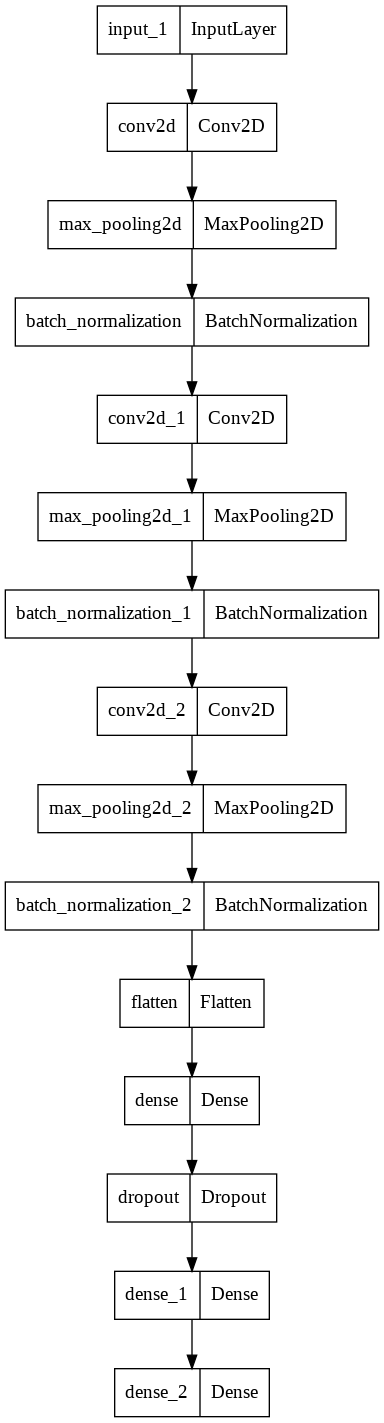

In [ ]:
plot_model(model_cnn)

In [ ]:
r1=model_cnn.fit(train_x,train_data.label,validation_split=0.1,epochs=20,callbacks=[reduceLR])

Epoch 1/20
77/77 [==============================] - 23s 193ms/step - loss: 1.2322 - accuracy: 0.6075 - val_loss: nan - val_accuracy: 0.2941 - lr: 0.0010
Epoch 2/20
77/77 [==============================] - 3s 41ms/step - loss: nan - accuracy: 0.3005 - val_loss: nan - val_accuracy: 0.2941 - lr: 0.0010
Epoch 3/20
77/77 [==============================] - 3s 40ms/step - loss: nan - accuracy: 0.3005 - val_loss: nan - val_accuracy: 0.2941 - lr: 1.0000e-04
Epoch 4/20
77/77 [==============================] - 3s 40ms/step - loss: nan - accuracy: 0.3005 - val_loss: nan - val_accuracy: 0.2941 - lr: 1.0000e-04
Epoch 5/20
77/77 [==============================] - 3s 41ms/step - loss: nan - accuracy: 0.3005 - val_loss: nan - val_accuracy: 0.2941 - lr: 1.0000e-05
Epoch 6/20
77/77 [==============================] - 3s 41ms/step - loss: nan - accuracy: 0.3005 - val_loss: nan - val_accuracy: 0.2941 - lr: 1.0000e-05
Epoch 7/20
77/77 [==============================] - 3s 41ms/step - loss: nan - accuracy: 0.

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r1.history['val_accuracy'])
plt.plot(r1.history['accuracy'])
plt.legend(['val_accuracy','accuracy'])
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r1.history['val_loss'])
plt.plot(r1.history['loss'])
plt.legend(['val_loss','loss'])
plt.show()

In [ ]:
# Predictions on Test Datasets using CNN model

test_pred=np.argmax(model_cnn.predict(test_x),axis=1)
print(classification_report(test_data.label,test_pred))

<h5 style="background-color:#f4a123;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px" ><b>Transfer Learning Approach (VGG 16)</b></h5>


## What is Transfer Learning?

Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task.
    In case of image processing we use some pretrained models like VGG-16,RasNet,VGG-19,etc. Which is trained on large ImageNet dataset.

## What is imagenet?

The ImageNet project is a large visual database designed for use in visual object recognition software research. More than 14 million images have been hand-annotated by the project to indicate what objects are pictured and in at least one million of the images, bounding boxes are also provided. ImageNet contains more than 20,000 categories with a typical category, such as "balloon" or "strawberry", consisting of several hundred images. 
    Here we use VGG-16 to train our model.
    
## What is VGG-16?

VGG16 (also called OxfordNet) is a convolutional neural network architecture named after the Visual Geometry Group from Oxford, who developed it. It was used to win the ILSVR (ImageNet) competition in 2014. VGG-16 is a convolutional neural network that is 16 layers deep. The network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224. 

In [ ]:
with tpu_strategy.scope():
    vgg_model = VGG16(weights='imagenet',include_top=False)
    for layers in vgg_model.layers:
        layers.trainable=False
    x=vgg_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(128,activation='relu')(x)
    x=Dropout(0.15)(x)
    output=Dense(4,activation='softmax')(x)
    model2=Model(inputs=vgg_model.input,outputs=output)
    model2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
plot_model(model2)

In [ ]:
r2=model2.fit(train_x,train_data.label,validation_split=0.1,epochs=20,callbacks=[early_stop,reduceLR])

Epoch 1/20
77/77 [==============================] - 21s 183ms/step - loss: 1.1760 - accuracy: 0.6611 - val_loss: 0.5018 - val_accuracy: 0.8382 - lr: 0.0010
Epoch 2/20
77/77 [==============================] - 3s 42ms/step - loss: 0.4307 - accuracy: 0.8418 - val_loss: 0.4166 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 3/20
77/77 [==============================] - 3s 41ms/step - loss: 0.3292 - accuracy: 0.8782 - val_loss: 0.4228 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 4/20
77/77 [==============================] - 3s 42ms/step - loss: 0.2596 - accuracy: 0.9064 - val_loss: 0.3277 - val_accuracy: 0.8897 - lr: 0.0010
Epoch 5/20
77/77 [==============================] - 3s 42ms/step - loss: 0.2243 - accuracy: 0.9158 - val_loss: 0.3129 - val_accuracy: 0.8934 - lr: 0.0010
Epoch 6/20
77/77 [==============================] - 3s 42ms/step - loss: 0.1865 - accuracy: 0.9330 - val_loss: 0.3253 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 7/20
77/77 [==============================] - 3s 42ms/step - loss: 0

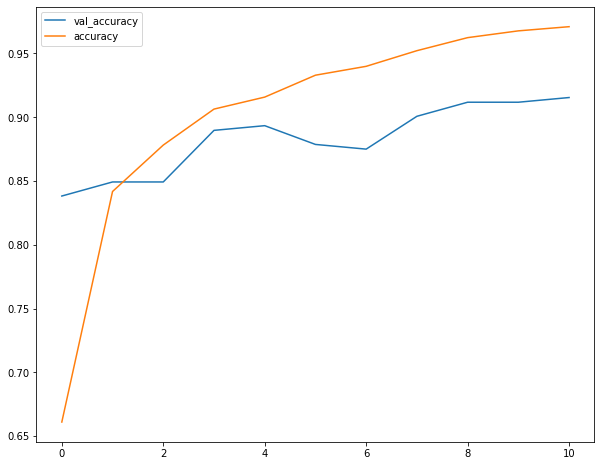

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r2.history['val_accuracy'])
plt.plot(r2.history['accuracy'])
plt.legend(['val_accuracy','accuracy'])
plt.show()

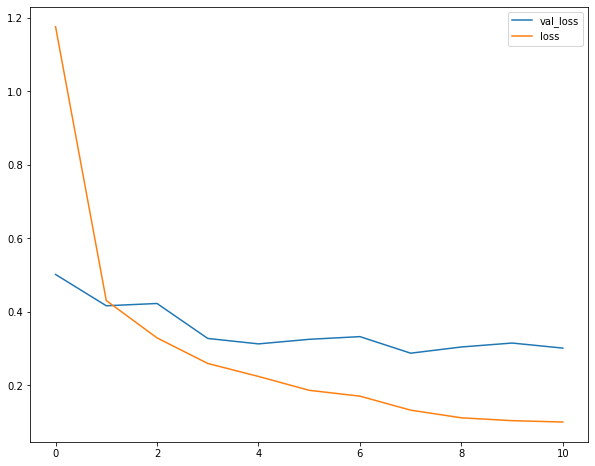

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r2.history['val_loss'])
plt.plot(r2.history['loss'])
plt.legend(['val_loss','loss'])
plt.show()

In [ ]:
# Predictions on Test Datasets using VGG16 model

test_pred_transfer=np.argmax(model2.predict(test_x),axis=1)
print(classification_report(test_data.label,test_pred_transfer))

              precision    recall  f1-score   support

           0       0.72      0.62      0.67        21
           1       0.05      0.12      0.07         8
           2       0.00      0.00      0.00        42
           3       0.13      0.19      0.15        31

    accuracy                           0.20       102
   macro avg       0.22      0.23      0.22       102
weighted avg       0.19      0.20      0.19       102



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_data.label,test_pred_transfer)

array([[13,  0,  7,  1],
       [ 1,  1,  5,  1],
       [ 2,  1,  0, 39],
       [ 2, 20,  3,  6]])

<h5 style="background-color:#a4adcb;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px" ><b>Visualizing Prediction on test dataset</b></h5>


IndexError: ignored

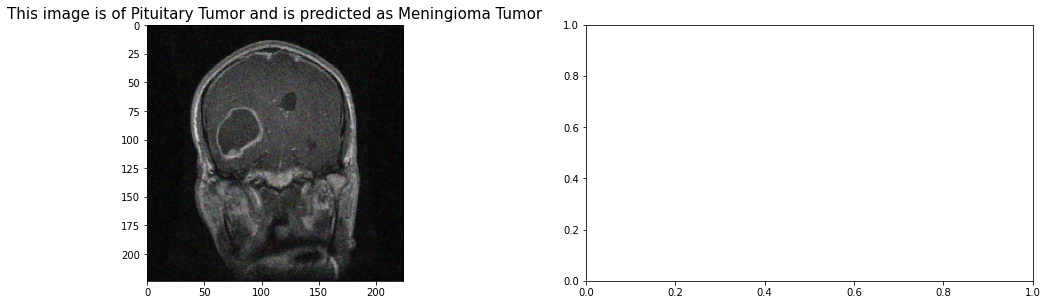

In [ ]:
# Prediction using VGG16 model

plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(200)
    pred_class=inverse_classes(np.argmax(model2.predict(np.reshape(test_x[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(test_data.label[index]),pred_class),
              fontdict={'size':15})
    plt.imshow(test_x[index])
    plt.tight_layout()

In [ ]:
# Prediction using CNN model

plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(200)
    pred_class=inverse_classes(np.argmax(model_cnn.predict(np.reshape(test_x[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(test_data.label[index]),pred_class),
              fontdict={'size':15})
    plt.imshow(test_x[index])
    plt.tight_layout()

<h5 style="background-color:#a41234;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px" ><b>Conclusion</b></h5>


## Here We could clearly observe that both the approaches worked quite well, with not much difference in accuracy. Though VGG16 model worked quite more efficiently, Because of two reasons:-
1. The validation accuracy and test accuracy is higher than the other method.
2. Time of computation and computation power is required lesser than traditional method as pretrained weights are used.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(test_data.label,test_pred_transfer)